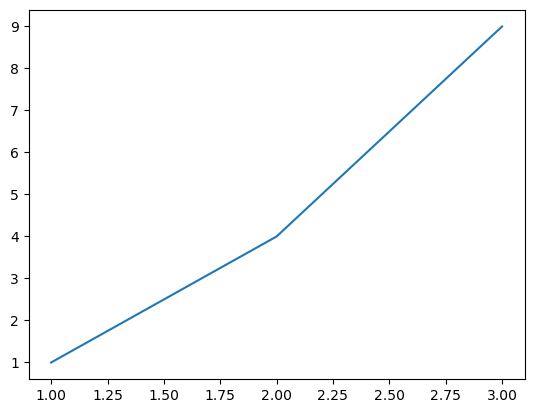

In [1]:
import matplotlib.pyplot as plt
plt.plot([1, 2, 3], [1, 4, 9])
plt.show()

In [2]:
import pytz
from datetime import datetime
from gym_mtsim import MtEnv, MtSimulator, Timeframe
from stable_baselines3 import A2C
import pandas as pd
import numpy as np

In [3]:
train_sim = MtSimulator(
    unit='USD',
    balance=10000.,
    leverage=200.,
    stop_out_level=0.2,
    hedge=False,
)

train_sim.download_data(
    symbols=['BITCOIN', 'ETHEREUM', 'MONERO', 'SOLANA', 'XRP'], # 'GBPCAD', 'GBPUSD', 'USDCAD', 'USDCHF', 'GBPJPY', 'USDJPY'
    time_range=(
        datetime(2023, 1, 1, tzinfo=pytz.UTC),
        datetime(2023, 6, 30, tzinfo=pytz.UTC)
    ),
    timeframe=Timeframe.H1
)

valid_sim = MtSimulator(
    unit='USD',
    balance=10000.,
    leverage=200.,
    stop_out_level=0.2,
    hedge=False,
)

valid_sim.download_data(
    symbols=['BITCOIN', 'ETHEREUM', 'MONERO', 'SOLANA', 'XRP'], # 'GBPCAD', 'GBPUSD', 'USDCAD', 'USDCHF', 'GBPJPY', 'USDJPY'
    time_range=(
        datetime(2023, 6, 30, tzinfo=pytz.UTC),
        datetime(2023, 8, 31, tzinfo=pytz.UTC)
    ),
    timeframe=Timeframe.H1
)

In [4]:
train_env = MtEnv(
    original_simulator=train_sim,
    trading_symbols=['ETHEREUM'], # 'GBPCAD', 'GBPUSD', 'USDCAD', 'USDCHF', 'GBPJPY', 'USDJPY'
    window_size=30,
    multiprocessing_processes=2
)

valid_env = MtEnv(
    original_simulator=valid_sim,
    trading_symbols=['ETHEREUM'], # 'GBPCAD', 'GBPUSD', 'USDCAD', 'USDCHF', 'GBPJPY', 'USDJPY'
    window_size=30,
    multiprocessing_processes=2
)

In [5]:
train_prices = train_env.get_prices()
valid_prices = valid_env.get_prices()

In [6]:
# just take the same values like in prices but loop over the symbold and concatinate the ndarray on axis 1
train_features = np.concatenate([train_prices[symbol] for symbol in train_prices], axis=1)
valid_features = np.concatenate([valid_prices[symbol] for symbol in valid_prices], axis=1)

In [7]:
train_env.add_signal_features(train_features)
valid_env.add_signal_features(valid_features)

train_env.build_spaces()
valid_env.build_spaces()

In [8]:
print("train_env information:")

for symbol in train_env.prices:
    print(f"> prices[{symbol}].shape:", train_env.prices[symbol].shape)

print("> signal_features.shape:", train_env.signal_features.shape)
print("> features_shape:", train_env.features_shape)

train_env information:
> prices[ETHEREUM].shape: (4288, 10)
> signal_features.shape: (4288, 10)
> features_shape: (30, 10)


In [9]:
print("valid_env information:")

for symbol in valid_env.prices:
    print(f"> prices[{symbol}].shape:", valid_env.prices[symbol].shape)

print("> signal_features.shape:", valid_env.signal_features.shape)
print("> features_shape:", valid_env.features_shape)

valid_env information:
> prices[ETHEREUM].shape: (1479, 10)
> signal_features.shape: (1479, 10)
> features_shape: (30, 10)


action: [16.80051187] reward: 0.33600000000005825 done: False
action: [-13.37392314] reward: -3.676749999999629 done: False
action: [67.01758505] reward: -38.774987825718384 done: False
action: [13.33707755] reward: 64.32649256511019 done: False
action: [16.59320561] reward: 17.254047276488194 done: False
action: [7.90698133] reward: 4.7431598378826685 done: False
action: [32.46607699] reward: 3.858474250969114 done: False
action: [-8.71041458] reward: 1.484586200678246 done: False
action: [-88.87731587] reward: 27.817418625349138 done: False
action: [66.5172833] reward: -52.43407776439061 done: False
action: [76.76765351] reward: 57.778093049470755 done: False
action: [-97.72009616] reward: -110.33349703830214 done: False
action: [79.48292552] reward: -96.5599254501386 done: False
action: [38.10607965] reward: 2.5576337477534383 done: False
action: [70.11418887] reward: 29.975817771118816 done: False
action: [49.65304518] reward: 19.84487815136059 done: False
action: [31.02211138] rew

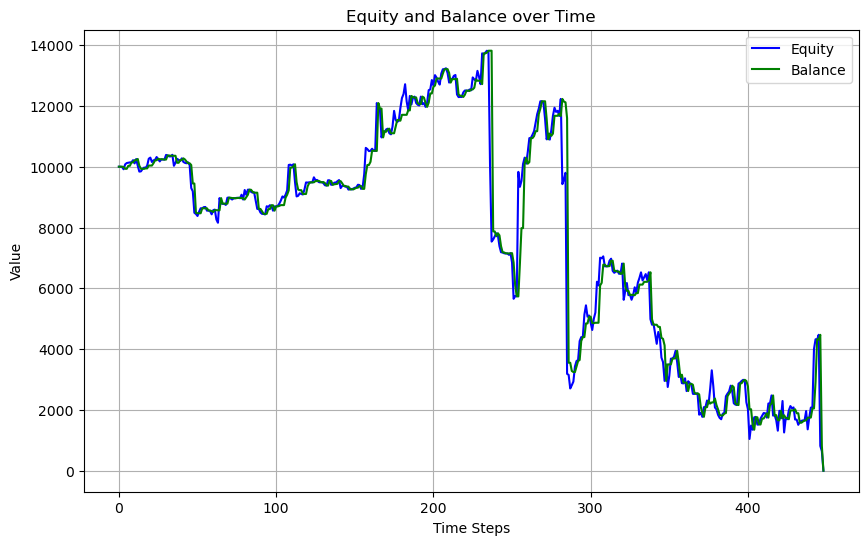

In [10]:
observation = train_env.reset()

while True:
    action = train_env.action_space.sample()
    observation, reward, done, _, info = train_env.step(action)
    print("action:", action, "reward:", reward, "done:", done)


    if done:
        print("Final Balance:", info['balance'][-1])
        train_env.render(mode='simple_figure')
        break

In [11]:
model = A2C('MultiInputPolicy', train_env, verbose=0)
observation = train_env.reset()

In [12]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

In [13]:
check_env(train_env)

c:\Users\stefa\anaconda3\envs\gymnasium-MT5\Lib\site-packages\stable_baselines3\common\env_checker.py:263: UserWarning: Your observation features has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
c:\Users\stefa\anaconda3\envs\gymnasium-MT5\Lib\site-packages\stable_baselines3\common\env_checker.py:453: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(
c:\Users\stefa\anaconda3\envs\gymnasium-MT5\Lib\site-packages\stable_baselines3\common\env_checker.py:464: UserWarning: Your action space has dtype float64, we recommend using np.float32 to avoid cast errors.
  warnings.warn(


Final Balance: 10385.52388834035


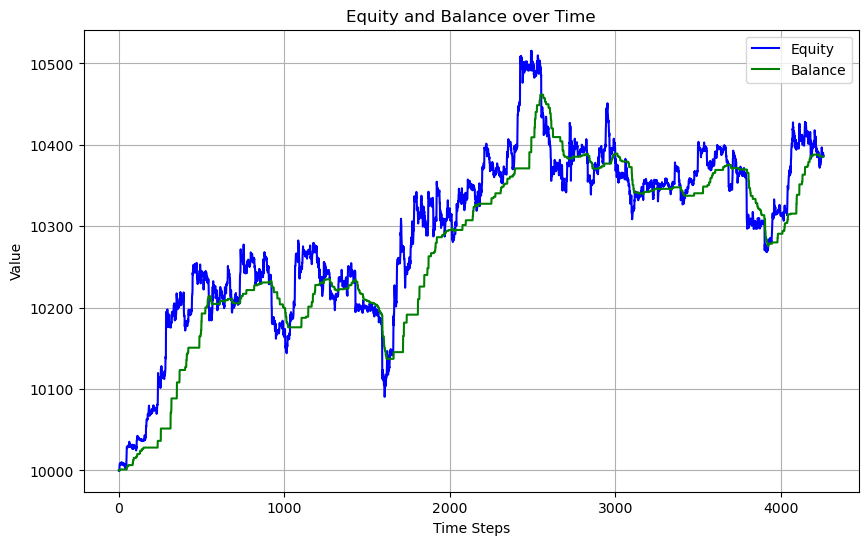

In [14]:
model.learn(total_timesteps=100)
import time
train_vec_env = model.get_env()
observation = train_vec_env.reset()

while True:
    action, _states = model.predict(observation, deterministic=True)
    action = action.flatten()
    observation, reward, done, _, info = train_env.step(action)
    if done:
        print("Final Balance:", info['balance'][-1])
        train_env.render(mode='simple_figure')
        break



Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Final Balance: 9863.903876359693


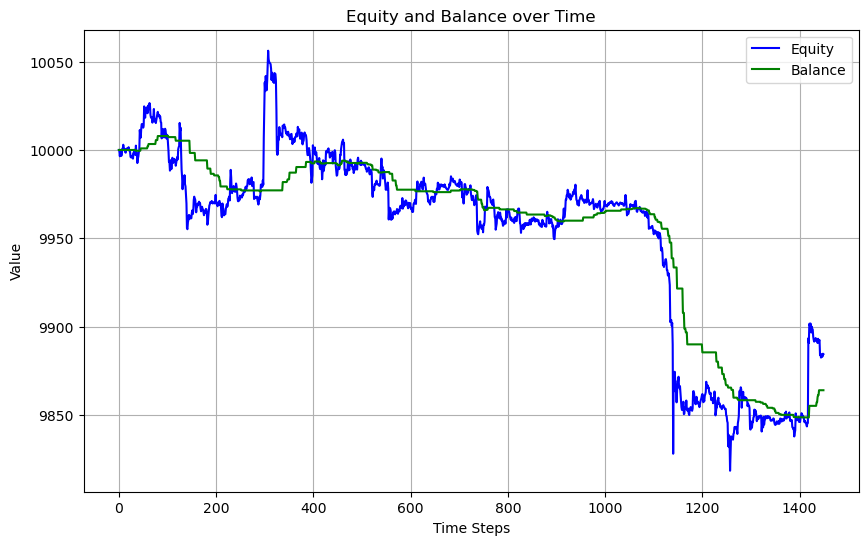

In [15]:
valid_vec_env = A2C('MultiInputPolicy', valid_env, verbose=1).get_env()

observation = valid_vec_env.reset()
while True:
    action, _states = model.predict(observation, deterministic=True)
    action = action.flatten()
    observation, reward, done, _, info = valid_env.step(action)

    if done:
        print("Final Balance:", info['balance'][-1])
        valid_env.render(mode='simple_figure')
        break

Final Balance: 12168.316036532011


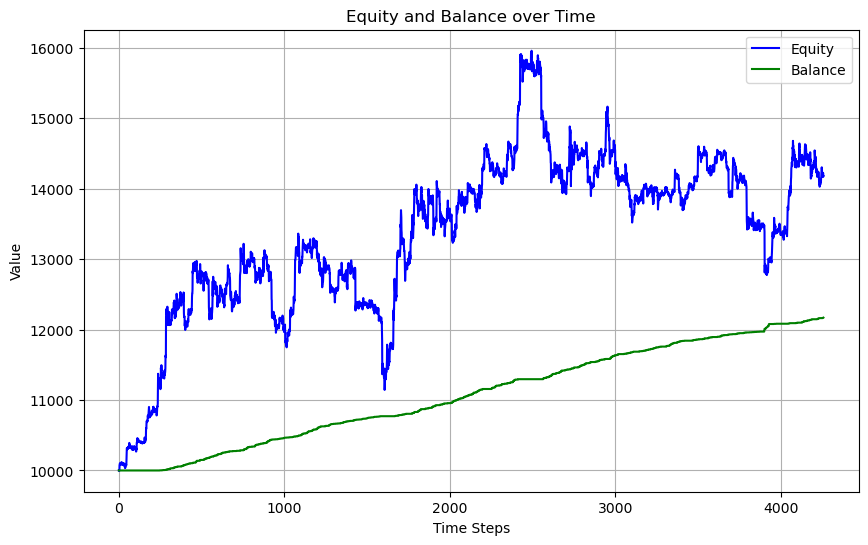

Final Balance valid_env: 10000.0


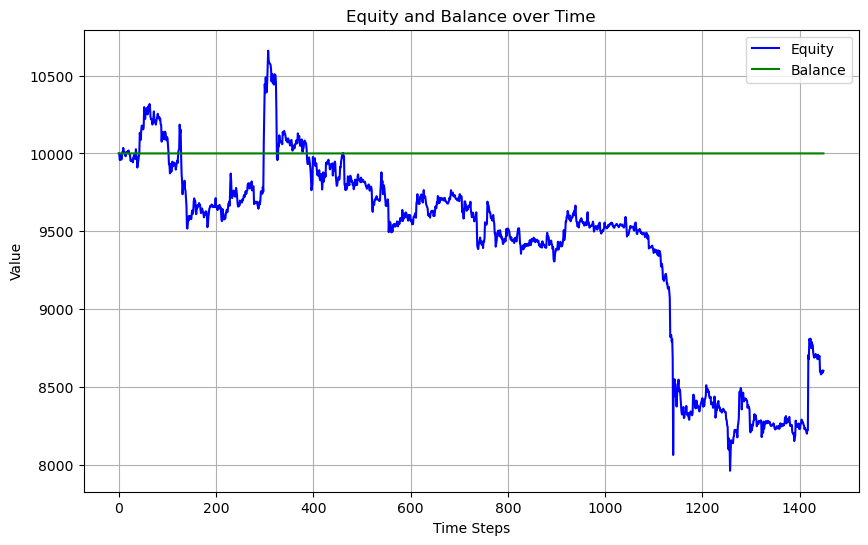

In [16]:
from IPython.display import clear_output


episodes = 400
timesteps = valid_env.signal_features.shape[0]
valid_balance = []

model = A2C('MultiInputPolicy', train_env, verbose=0)
model.learn(total_timesteps=100)
train_vec_env = model.get_env()
valid_vec_env = A2C('MultiInputPolicy', valid_env, verbose=1).get_env()
observation = train_vec_env.reset()


for episode in range(episodes):
    # delete the cell output
    clear_output(wait=True)
    
    model.learn(total_timesteps=timesteps)
    
    observation = train_vec_env.reset()
    counter = 0

    # Correct handling of vectorized environments if using them
    while True:
        action, _states = model.predict(observation, deterministic=True)
        action = action.flatten()
        observation, reward, done, _, info = train_env.step(action)

        # If done is an array (for vectorized environments), check any True
        if isinstance(done, np.ndarray):
            done = done.any()

        if done:
            print("Final Balance:", info['balance'][-1])
            train_env.render(mode='simple_figure')
            break

            
    observation = valid_vec_env.reset()
    while True:
        action, _states = model.predict(observation, deterministic=True)
        action = action.flatten()
        observation, reward, done, _, info = valid_env.step(action)

        if done:
            print("Final Balance valid_env:", info['balance'][-1])
            valid_balance.append(info['balance'][-1])
            valid_env.render(mode='simple_figure')
            break
            
    # save the model if it is the best so far
    if valid_balance[-1] == max(valid_balance):
        model.save('best_model')

model = A2C.load('best_model')